In [335]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import scipy.stats as st
from astropy.table import Table
from astropy.io import ascii
from scipy.optimize import fmin_cg

In [367]:
#Initiation of data, now loading GRD1 data and setting up the various parameters used in the code below

try:
    data_raw
except NameError:
    
    data_raw = ascii.read('Distances_PJM2017.csv', format='fast_csv')

#data = data_raw[0:10000]
    
RA = data_raw['RAdeg']*u.degree
DEC = data_raw['DEdeg']*u.degree
pm_RA = data_raw['pmRA_TGAS']*u.mas/u.yr
pm_DEC = data_raw['pmDE_TGAS']*u.mas/u.yr
parallax = data_raw['parallax']*u.mas
dist = data_raw['distance']*u.pc

near_stars = np.where(dist.value<100)

sample_raw = coord.ICRS(ra = RA, dec = DEC, pm_ra_cosdec = pm_RA, pm_dec = pm_DEC)

sample = sample_raw[near_stars]
parallax = parallax[near_stars]

sample = sample.transform_to(coord.Galactic)

In [419]:
def model_sample(N): 

    """Generates a simple model solar neighbourhood star sample assuming a Gaussian velocity distribution."""

    pml0 = -25
    pmb0 = -10
    pmlstd = 100
    pmbstd = 100
    
    lvals = np.random.uniform(0,360,N)
    bvals = np.random.uniform(-90,90,N)
    
    pml = 100*np.random.randn(N)+pml0
    pmb = 75*np.random.randn(N)+pmb0
    
    psample = coord.Galactic(l=lvals*u.deg,b=bvals*u.deg,pm_l_cosb=pml*(u.mas/u.yr),pm_b=pmb*(u.mas/u.yr))
    
    #scale = np.random.randn(N,3)
    #pspvels = v0 + scale*disp
    
    psdist = (np.random.rand(N)*(0.1-0.01)+0.01)*u.kpc
    
    return psample, psdist

In [424]:
#Oort constant values from Bovy (2018)
A = (15.3*(u.km/(u.s*u.kpc))).to(1/u.yr)
B = (-11.9*(u.km/(u.s*u.kpc))).to(1/u.yr)

N = 1000
sample, parallax = model_sample(N) #Uncomment to use pseudosample

bvals = sample.b.to(u.deg)
lvals = sample.l.to(u.deg)

mul_obs = sample.pm_l_cosb.to(1/u.yr,equivalencies = u.dimensionless_angles())
mub_obs = sample.pm_b.to(1/u.yr,equivalencies = u.dimensionless_angles())

"""Computation of the relevant quantities

    l,b: Galactic coordinates
    s: the distance obtained by inverting the parallax
    mul, mub: proper motion in l and b
    pvals: Tangential velocities obtained from eq. 2 in DB98
    rhatvals: The unit vector of each star
    vmin: Vector containing the minimum velocities in v-space
    n: The number of cells we want in each dimension of our v-space box
    dv: Step sizes for each dimension"""

b = np.deg2rad(bvals).value # just a test
l = np.deg2rad(lvals).value
cosl = np.cos(l)
cosb = np.cos(b)
sinl = np.sin(l)
sinb = np.sin(b)
s = parallax.to(u.kpc,equivalencies=u.parallax())

mul = mul_obs - A*np.cos(2*l)-B
mub = mub_obs + A*np.sin(2*l)*cosb*sinb

pvals = s*np.array([-sinl*cosb*mul - cosl*sinb*mub,
                 cosl*cosb*mul - sinl*sinb*mub,
                 cosb*mub])/u.yr
    
rhatvals = np.array([cosb*cosl, cosb*sinl, sinb]).T
pvals = pvals.to(u.km/u.s).value.T

"""Test values for our functions"""

vmin = np.array([-200,-200,-200])

n = np.array([10,10,10])

dv = np.array([40,40,40])

In [425]:
def calc_K(pk,rhat,vmin,dv,n):
    '''Calculate the values of K simultaneously for all bins for a given star with p, rhat'''
    
    vxmin, vymin, vzmin = vmin
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    pkx, pky, pkz = pk
    rhatx, rhaty, rhatz = rhat
    
    K = np.zeros((nx,ny,nz))
    
    vxmax, vymax, vzmax = vxmin+nx*dvx,vymin+ny*dvy,vzmin+nz*dvz
    
    """We now solve the line equation v = pk + vr*rhat, where v are the intersections of the line 
    and the boundaries of each bin"""
    
    vx_bins = np.arange(vxmin, vxmax+dvx, dvx)
    vy_bins = np.arange(vymin, vymax+dvy, dvy)
    vz_bins = np.arange(vzmin, vzmax+dvz, dvz)
    
    vrx = (vx_bins-pkx)/rhatx
    vry = (vy_bins-pky)/rhaty
    vrz = (vz_bins-pkz)/rhatz
    
    """After solving the line equation for each dim we remove the vr values which solve the equation
    for bins outside of our specified box."""
    
    vrmax = min(max(vrx),max(vry),max(vrz))
    vrmin = max(min(vrx),min(vry),min(vrz))
    
    vrx = vrx[(vrx<=vrmax) & (vrx>=vrmin)]
    vry = vry[(vry<=vrmax) & (vry>=vrmin)]
    vrz = vrz[(vrz<=vrmax) & (vrz>=vrmin)]
    vr = np.concatenate((vrx,vry,vrz))
    vr.sort() #We obtain an ordered list with all vr values for intersections between entry and exit points
    
    if len(vr)==0:
        return K
    
    vr_prime =(vr[:-1] + vr[1:]) / 2
    line_bins = np.zeros((len(vr_prime),3))

    pk = np.stack([pk]*len(vr_prime))
    rhat = np.stack([rhat]*len(vr_prime))
    vmin = np.stack([vmin]*len(vr_prime))
    vr_primestack = np.stack([vr_prime]*3,axis=1)

    """We now solve the line equation again for values in the middle of each bin with a line segment in it.
    This gives us the coordinates for each relevant bin, given in line_bins.
    Finally we computhe the length of each segment and add said value to the relevant box in our K-space."""
    v_prime = pk + vr_primestack*rhat
    line_bins += np.floor((v_prime-vmin)/ dv)
      
    line_bins = line_bins.astype(int)
    
    line_len = vr[1:]-vr[:-1]
    non_zero = np.nonzero(line_len)
    line_len = line_len[non_zero]
    line_bins = line_bins[non_zero]
    
    K[line_bins[:,0],line_bins[:,1],line_bins[:,2]] = line_len/(dvx*dvy*dvz)
    
    return K

In [426]:
def calc_sigma2(pvals,rhat):
    
    """Function that applies equation 12 of DB98 for a set of stars from their tangential velocities and unit vectors.
    Returns the velocity dispersion tensor."""
    
    pmean = np.mean(pvals, axis=0)
    
    rhat_outer = rhat[:,:,None]*rhat[:,None,:] #Fast way of getting the outer product for each rhat with itself.

    iden = np.identity(3)
    
    A = np.stack([iden]*len(rhat_outer))-rhat_outer #Eq. 4 in DB98. Yields an array of dim (N_star,3,3)
    
    A_mean = np.mean(A,axis=0)
    A_mean_inv = np.linalg.inv(A_mean)
    v_mean = np.dot(A_mean_inv, pmean)
    
    pp = pvals - np.dot(A,v_mean)
    
    pp2mean = np.mean(pp*pp,axis=0)
    
    B = np.array([[9,-1,-1],[-1,9,-1],[-1,-1,9]])
    
    sigma2 = (3/14)*np.dot(B,pp2mean)
    
    return sigma2

In [427]:
def nl_delta(n,l):
    
    """Checks if our given vector n is within one unit vector e_i of the cell l
    
    First attempt at solving the problem, so can be ignored"""
    
    e_x = np.array([1,0,0])
    e_y = np.array([0,1,0])
    e_z = np.array([0,0,1])
    
    rules = [np.array_equal(n,l+e_x),
            np.array_equal(n,l-e_x),
            np.array_equal(n,l+e_y),
            np.array_equal(n,l-e_y),
            np.array_equal(n,l+e_z),
            np.array_equal(n,l-e_z)]
    
    if np.array_equal(n,l):
        delta = -2
    elif any(rules):
        delta = 1
    else:
        delta = 0
    
    return delta
        
def calc_xhi(line_bins,sigma2,hx,hy,hz,nx,ny,nz):

    """Given a vector l, find the estimate of the second derivative. Compare l with possible adjacent n values.
    
    Was also scrapped for a more efficient method sec_der"""   
    
    h2 = np.array([hx**2,hy**2,hz**2])
    
    xhi = np.zeros((len(line_bins),7))
    
    n_bins = np.array([nx,ny,nz])
    
    e_x = np.array([1,0,0])
    e_y = np.array([0,1,0])
    e_z = np.array([0,0,1])
    
    for i in range(len(line_bins)):
        
        l = line_bins[i]
        
        n_list = [l,
                 l+e_x,l-e_x,
                 l+e_y,l-e_y,
                 l+e_z,l-e_z]
        
        print(n_list)
        
        for j in range(7):
            
            n = n_list[j]
            
            if (all(n>=0)) and (all(n<=n_bins)):
                xhi[i][j] += np.sum((sigma2/h2) *  nl_delta(n,l))

    return xhi

In [428]:
def sec_der(phi,sigma2,dv):
    
    """Estimates the second deriative for ln(f(v_l)) given a sample of stars (eq. 30 of D98).
    Takes contributions at the phi values of adjacent bins for each bin l.
    
    We create a new, larger box with dimensions n+2 centred on our phi-space box.
    This allows us to disregard any issues at the bins at the boundaries of our phi-space."""
    
    nx, ny, nz = phi.shape
    dv2 = dv**2
    
    nxx, nyy, nzz = nx+2, ny+2, nz+2 

    phip = np.zeros((nxx,nyy,nzz)) #new larger box

    phip[1:-1,1:-1,1:-1] = phi #puts the phi-box in the centre of our larger box
    
    kappa = sigma2/dv2
    
    kappa_sum = -2*sum(sigma2/dv2)
    
    """Here we compute the contributions from all the adjacent bins simultaneously.
    In every dimension we sum the phi values of box l-1 and l+1 and multiply with the relevant factor"""
    
    phi_fac = np.array([phip[0:nxx-2,1:-1,1:-1]+phip[2:nxx,1:-1,1:-1],
                           phip[1:-1,0:nyy-2,1:-1]+phip[1:-1,2:nyy,1:-1],
                           phip[1:-1,1:-1,0:nzz-2]+phip[1:-1,1:-1,2:nzz]])

    phi_arrx = (sigma2[0]/dv2[0])*phi_fac[0]
    phi_arry = (sigma2[1]/dv2[1])*phi_fac[1]
    phi_arrz = (sigma2[2]/dv2[2])*phi_fac[2]
    
    """We sum all contributions from adjacent boxes and finally add the terms for each box l. 
    Yields a box with the same dimensions as phi, containing the second derivative values for each bin."""
    
    phi_arr = phi_arrx+phi_arry+phi_arrz+kappa_sum*phi 

    return phi_arr

In [429]:
def phi_guess(v0,disp,vmin,dv,n):
    
    """Provides an initial guess of the phi values in each bin. For now only allows for a Gaussian type guess given arrays
    with mean velocities and dispersions for each dimension."""
    
    vxmin, vymin, vzmin = vmin
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    v0x, v0y, v0z = v0
    dispx, dispy, dispz = disp
    
    vxmax, vymax, vzmax = vxmin+nx*dvx,vymin+ny*dvy,vzmin+nz*dvz
    
    vx_bins = np.arange(vxmin, vxmax+dvx, dvx)
    vy_bins = np.arange(vymin, vymax+dvy, dvy)
    vz_bins = np.arange(vzmin, vzmax+dvz, dvz)
    
    vxc = (vx_bins[1:]+vx_bins[:-1])/2
    vyc = (vy_bins[1:]+vy_bins[:-1])/2
    vzc = (vz_bins[1:]+vz_bins[:-1])/2
    
    """Given the velocities of each bin we compute the 3D Gaussian value."""
    
    gx = st.norm(v0x,dispx)
    gy = st.norm(v0y,dispy)
    gz = st.norm(v0z,dispz)
    
    gxp = gx.pdf(vxc)
    gyp = gy.pdf(vyc)
    gzp = gz.pdf(vzc)
    
    phix, phiy, phiz = np.meshgrid(gxp,gyp,gzp)
    
    phi = np.array([phix,phiy,phiz])
    
    phi_sum = np.sum(phi,axis=0)
    
    return phi_sum.T

In [430]:
def get_L(phi,*args):
    
    """The function that we wish to optimise."""
    
    Kvals, N, alpha, dv, n, sigma2 = args
    nx, ny, nz = n
    dvx, dvy, dvz = dv
    
    """We regain the original shape of our phi guess and proceed to compute the various quantities needed from our functions."""
    
    phi_unr = np.reshape(phi,n)
    
    phixhi = sec_der(phi_unr,sigma2,dv) #last term
    
    exphi = np.exp(phi_unr)
    
    Kphi = exphi*Kvals
    
    Kphiord = Kphi.reshape(len(Kphi),nx*ny*nz) #Order all Kphi values in arrays for each star
    
    Kphi_sum = np.sum(Kphiord,axis=1) #We compute the sum of exp(phi)*K(k|l) for each star
    
    notzero = Kphi_sum != 0
    
    Kphi_sum[notzero] = np.log(Kphi_sum[notzero]) #To make sure we don't get infinities
    
    Kphi_sum_tot = np.sum(Kphi_sum) #Gives the double sum in the first term
        
    L_tilde = Kphi_sum_tot/N - np.sum(exphi)-((alpha*dvx*dvy*dvz)/2)*np.sum(phixhi**2)
    
    negL = -1*(L_tilde+1)
    
    return negL

In [431]:
def max_L(alpha, pvals, rhatvals, vmin, dv, n):
    
    """Function that employs scipy.optimize.fmin_cg to maximise the function get_L()"""
    
    v0_guess = np.array([0,0,0]) #Just a guess of the Gaussian parameters
    disp_guess  = np.array([30,30,30])
    
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    
    N = len(pvals)
    
    phi0 = phi_guess(v0_guess,disp_guess,vmin,dv,n)
    
    sigma2 = calc_sigma2(pvals,rhatvals)
    
    Kvals = np.zeros((N,nx,ny,nz))
    
    for i in range(N):
        K = calc_K(pvals[i],rhatvals[i],vmin,dv,n)
        Kvals[i] += K   
        
    args = (Kvals, N, alpha, dv, n, sigma2)
    
    phi0 = np.ravel(phi0)
    
    mxl = fmin_cg(get_L, phi0, args=args,retall=True)
    
    mxlnew = -mxl.reshape(n)
    
    return mxlnew
   
    #return get_L(phi0, Kvals, N, alpha, dv, n, sigma2)

In [ ]:
mxl = max_L(1, pvals, rhatvals, vmin, dv, n)

In [398]:
def plot_fv(phi,plane,vmin,dv,n):
    
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    vxmin, vymin, vzmin = vmin
    vxmax, vymax, vzmax = vxmin+nx*dvx,vymin+ny*dvy,vzmin+nz*dvz
    
    if plane == 'xy':
        axsum = 2
        n1, n2 = nx, ny
        dx, dy = dvx, dvy
        x0, y0 = vxmin, vymin
        x1, y1 = vxmax, vymax
        xlab, ylab = '$v_x$', '$v_y$'
    elif plane == 'yz':
        axsum = 0
        n1, n2 = ny, nz
        dx, dy = dvy, dvz
        x0, y0 = vymin, vzmin
        x1, y1 = vymax, vzmax
        xlab, ylab = '$v_y$', '$v_z$'
    elif plane == 'xz':
        axsum = 1
        n1, n2 = nx, nz
        dx, dy = dvx, dvz
        x0, y0 = vxmin, vzmin
        x1, y1 = vxmax, vzmax
        xlab, ylab = '$v_x$', '$v_z$'
        
    fv = np.exp(phi)
    
    twodfv = np.sum(fv,axis=axsum)
    
    xbins = np.arange(x0,x1+dx,dx)
    ybins = np.arange(y0,x1+dy,dy)
    
    xc = (xbins[1:]+xbins[:-1])/2
    yc = (ybins[1:]+ybins[:-1])/2
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.set_title('Contour plot of velocity distribution')
    ax.set_xlim(x0,x1)
    ax.set_ylim(y0,y1)
    ax.set_xlabel(xlab+' [km s$^{-1}$]',size='large')
    ax.set_ylabel(ylab+' [km s$^{-1}$]',size='large')
    
    plt.contourf(xc,yc,twodfv,cmap = plt.cm.get_cmap('jet'))
    
    #extent = [xc[0], xc[-1], yc[0], yc[-1]]
    #plt.imshow(twodfv.T,origin='lower',interpolation='bilinear',vmin=0,vmax=twodfv.max(),cmap = plt.cm.get_cmap('jet'),extent=extent)
    
    cb = plt.colorbar(orientation='vertical', extend='max')
    cb.set_label('Number density of stars',size='large')
    
    plt.show()
    
    return

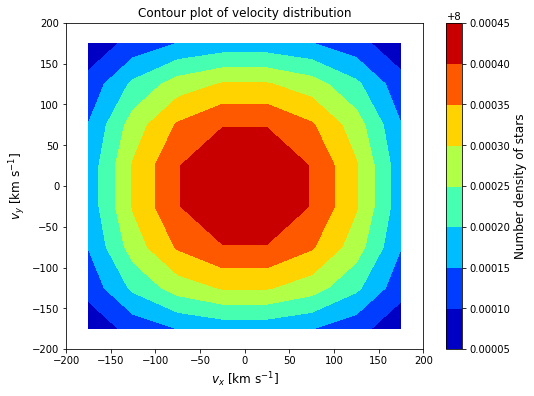

In [399]:
plot_fv(mxl,'xy',vmin,dv,n)

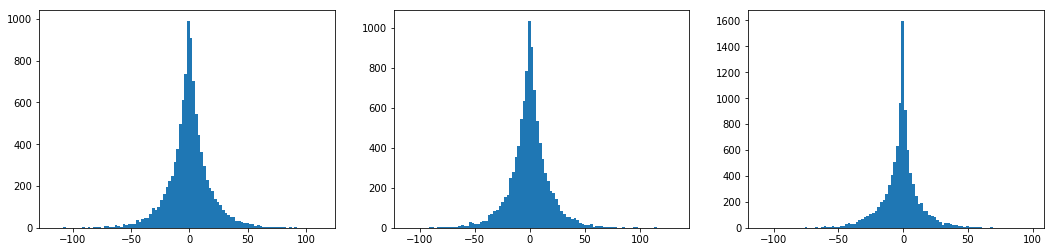

In [400]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,4))
ax1.hist(pvals[:,0],bins=100)
ax2.hist(pvals[:,1],bins=100)
ax3.hist(pvals[:,2],bins=100)
plt.show()

In [401]:
pxstd, pxmean = pvals[:,0].std(), pvals[:,0].mean()
pystd, pymean = pvals[:,1].std(), pvals[:,1].mean()
pzstd, pzmean = pvals[:,2].std(), pvals[:,2].mean()

v0 = np.array([pxmean,pymean,pzmean])
disp = np.array([pxstd,pystd,pzstd])

phi0 = phi_guess(v0,disp,vmin,dv,n)

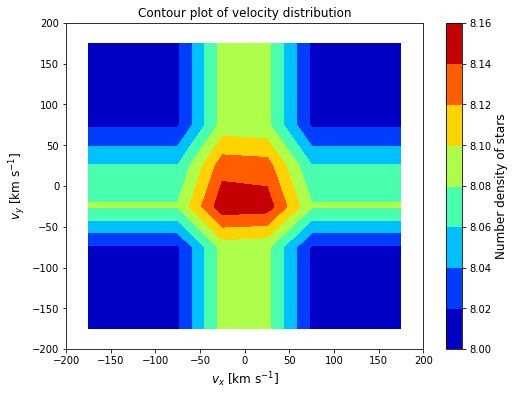

In [402]:
plot_fv(phi0,'xy',vmin,dv,n)

In [422]:
pvals.max()

114.2741504316335